# Draft / Ideas: Multilingual Evaluation

This notebook evaluates the fine-tuned XLM-RoBERTa model on custom text from multiple languages (English, French and Italian) to test performance on new text.

In [1]:
# Import required libraries
import json
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from typing import List, Dict, Tuple, Optional

# Hugging Face libraries
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    pipeline
)
import torch

import warnings
warnings.filterwarnings('ignore')

print("✓ Libraries imported")

✓ Libraries imported


In [2]:
import torch

# Detect device and set it explicitly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [3]:
# Configure paths
MODEL_PATH = Path("../models/litbank-xlm-roberta")
PROCESSED_DATA_PATH = Path("../data/processed")
RESULTS_PATH = Path("../results")
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

# Check if model exists
if not MODEL_PATH.exists():
    print(f"⚠️  Model not found at {MODEL_PATH}")
    print("Please run Notebook 2 (Model Training) first to train the model.")
else:
    print(f"✓ Found trained model at: {MODEL_PATH.absolute()}")

✓ Found trained model at: c:\Users\niw\Documents\CAS NLP Mod4\Mod4_Project\module4-transformers\notebooks\..\models\litbank-xlm-roberta


## 1. Load Fine-tuned Model

We'll load the XLM-RoBERTa model trained on English LitBank data.

In [4]:
# Load model and tokenizer
print("Loading fine-tuned model...")

tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForTokenClassification.from_pretrained(MODEL_PATH).to(device)

# Load label mapping
with open(PROCESSED_DATA_PATH / "label_mapping.json", 'r') as f:
    label_mapping = json.load(f)

label2id = label_mapping["label2id"]
id2label = {int(k): v for k, v in label_mapping["id2label"].items()}

print(f"\n✓ Model loaded successfully")
print(f"  Model: XLM-RoBERTa fine-tuned on LitBank")
print(f"  Parameters: {model.num_parameters():,}")
print(f"  Entity types: {len([l for l in label2id if l.startswith('B-')])}")
print(f"\nSupported entity types:")
entity_types = sorted(set([l[2:] for l in label2id.keys() if l.startswith('B-')]))
for entity_type in entity_types:
    print(f"  - {entity_type}")

Loading fine-tuned model...


The tokenizer you are loading from '..\models\litbank-xlm-roberta' with an incorrect regex pattern: https://huggingface.co/mistralai/Mistral-Small-3.1-24B-Instruct-2503/discussions/84#69121093e8b480e709447d5e. This will lead to incorrect tokenization. You should set the `fix_mistral_regex=True` flag when loading this tokenizer to fix this issue.



✓ Model loaded successfully
  Model: XLM-RoBERTa fine-tuned on LitBank
  Parameters: 277,463,053
  Entity types: 7

Supported entity types:
  - FAC
  - GPE
  - LOC
  - ORG
  - PER
  - TIME
  - VEH


## 2. Create NER Pipeline

- Simplifies inference (handles tokenization, prediction, decoding)
- Aggregates subword predictions into word-level entities
- Provides confidence scores

Example test passage from Charles Dickens' *Christmas Carol*

In [5]:
# Create NER pipeline
ner_pipeline = pipeline(
    "token-classification",
    model=model,
    tokenizer=tokenizer,
    aggregation_strategy="simple",  # Aggregate subwords into entities
    device=0 if torch.cuda.is_available() else -1  # Use GPU if available
)

print("✓ NER pipeline created")
print(f"  Device: {'GPU' if torch.cuda.is_available() else 'CPU'}")

# Test on example sentence
test_sentence = "Although they had but that moment left the school behind them, they were now in the busy thoroughfares of a city, where shadowy passengers passed and re-passed; where shadowy carts and coaches battled for the way, and all the strife and tumult of a real city were. It was made plain enough, by the dressing of the shops, that here, too, it was Christmas-time again; but it was evening, and the streets were lighted up. The Ghost stopped at a certain warehouse door, and asked Scrooge if he knew it."
print(f"\nTest prediction:")
print(f"  Input: {test_sentence}")
predictions = ner_pipeline(test_sentence)
print(f"\n  Detected entities:")
for entity in predictions:
    print(f"    - {entity['word']:20s} → {entity['entity_group']:6s} (confidence: {entity['score']:.3f})")

Device set to use cpu


✓ NER pipeline created
  Device: CPU

Test prediction:
  Input: Although they had but that moment left the school behind them, they were now in the busy thoroughfares of a city, where shadowy passengers passed and re-passed; where shadowy carts and coaches battled for the way, and all the strife and tumult of a real city were. It was made plain enough, by the dressing of the shops, that here, too, it was Christmas-time again; but it was evening, and the streets were lighted up. The Ghost stopped at a certain warehouse door, and asked Scrooge if he knew it.

  Detected entities:
    - the school           → FAC    (confidence: 0.812)
    - the busy thoroughfares of → FAC    (confidence: 0.907)
    - a city               → GPE    (confidence: 0.868)
    - ,                    → FAC    (confidence: 0.543)
    - shadowy passengers   → PER    (confidence: 0.962)
    - shadowy carts        → VEH    (confidence: 0.508)
    - coaches              → VEH    (confidence: 0.497)
    - a real city 

In [6]:
# Color-coded NER visualization
from IPython.display import HTML, display

def display_ner_results(text: str, entities: List[Dict], show_confidence: bool = True):
    """
    Display NER results with color-coded entity tags.
    
    Args:
        text: Input text
        entities: List of entity predictions from the pipeline
        show_confidence: Whether to show confidence scores
    """
    # Define colors for each entity type
    entity_colors = {
        'PER': '#ffa07a',  # Light salmon
        'ORG': '#87ceeb',  # Sky blue
        'LOC': '#98fb98',  # Pale green
        'GPE': '#dda0dd',  # Plum
        'FAC': '#f0e68c',  # Khaki
        'VEH': '#ffb6c1',  # Light pink
    }
    
    # Sort entities by their start position
    sorted_entities = sorted(entities, key=lambda x: x['start'])
    
    # Build HTML with highlighted entities
    html_parts = []
    last_end = 0
    
    for entity in sorted_entities:
        start = entity['start']
        end = entity['end']
        entity_text = entity['word']
        entity_type = entity['entity_group']
        confidence = entity['score']
        
        # Add text before entity
        if start > last_end:
            html_parts.append(text[last_end:start])
        
        # Add highlighted entity
        color = entity_colors.get(entity_type, '#d3d3d3')
        tooltip = f"{entity_type}"
        if show_confidence:
            tooltip += f" ({confidence:.2f})"
        
        html_parts.append(
            f'<mark style="background-color: {color}; padding: 2px 4px; '
            f'margin: 0 2px; border-radius: 3px; font-weight: bold;" '
            f'title="{tooltip}">'
            f'{entity_text} '
            f'<sup style="font-size: 0.7em; color: #555;">[{entity_type}]</sup>'
            f'</mark>'
        )
        
        last_end = end
    
    # Add remaining text
    if last_end < len(text):
        html_parts.append(text[last_end:])
    
    # Create legend
    legend_html = '<div style="margin-top: 20px; padding: 10px; background-color: #f5f5f5; border-radius: 5px;">'
    legend_html += '<strong>Entity Types:</strong><br>'
    for entity_type, color in entity_colors.items():
        legend_html += f'<span style="background-color: {color}; padding: 2px 8px; margin: 2px; border-radius: 3px; display: inline-block;">{entity_type}</span> '
    legend_html += '</div>'
    
    # Combine everything
    full_html = f'<div style="line-height: 2.0; font-size: 14px;">{"".join(html_parts)}</div>{legend_html}'
    
    display(HTML(full_html))

# Display the test sentence with color-coded entities
print("NER Results:")
display_ner_results(test_sentence, predictions, show_confidence=True)

NER Results:


### French Text Example

Test the model's performance with custom French literary text (passage from Guy de Maupassant's *Pierre et Jean*).

In [7]:
# French test passage - replace with your own text
french_text = "Les cabines roulantes, attelées d'un cheval, remontaient aussi; et sur les planches de la promenade, qui borde la plage d'un bout à l'autre, c'était maintenant une coulée continue, épaisse et lente, de foule élégante, formant deux courants contraires qui se coudoyaient et se mêlaient. Pierre, nerveux, exaspéré par ce frôlement, s'enfuit, s'enfonça dans la ville et s'arrêta pour déjeuner chez un simple marchand de vins, à l'entrée des champs."

# Get predictions
french_predictions = ner_pipeline(french_text)

print("Detected entities:")
for entity in french_predictions:
    print(f"  - {entity['word']:25s} → {entity['entity_group']:6s} (confidence: {entity['score']:.3f})")

# Display with color-coded tags
print("\nFrench NER Results:")
display_ner_results(french_text, french_predictions, show_confidence=True)

Detected entities:
  - cabines                   → VEH    (confidence: 0.306)
  - cheval                    → VEH    (confidence: 0.380)
  - promenade                 → FAC    (confidence: 0.635)
  - la plage                  → LOC    (confidence: 0.776)
  - Pierre                    → PER    (confidence: 0.969)
  - la ville                  → GPE    (confidence: 0.744)
  - un simple marchand de vins → PER    (confidence: 0.782)
  - des champs                → LOC    (confidence: 0.614)

French NER Results:


### Italian Text Example

Test the model's performance with custom Italian literary text (passage from Carlo Collodi's *Pinocchio*).

In [8]:
# Italian test passage - replace with your own text
italian_text = "E parve che Geppetto, sebbene fosse molto lontano dalla spiaggia, riconoscesse il figliuolo, perchè si levò il berretto anche lui e lo salutò e, a furia di gesti, gli fece capire che sarebbe tornato volentieri indietro, ma il mare era tanto grosso, che gl'impediva di lavorare col remo e di potersi avvicinare alla terra."

# Get predictions
italian_predictions = ner_pipeline(italian_text)

print("Detected entities:")
for entity in italian_predictions:
    print(f"  - {entity['word']:25s} → {entity['entity_group']:6s} (confidence: {entity['score']:.3f})")

# Display with color-coded tags
print("\nItalian NER Results:")
display_ner_results(italian_text, italian_predictions, show_confidence=True)

Detected entities:
  - Geppetto                  → PER    (confidence: 0.944)
  - spiaggia                  → LOC    (confidence: 0.760)
  - figli                     → PER    (confidence: 0.800)
  - olo                       → PER    (confidence: 0.537)
  - il mare                   → LOC    (confidence: 0.811)
  - terra                     → LOC    (confidence: 0.558)

Italian NER Results:


## Attention Weight Visualization

**Why visualize attention?**
- Shows which tokens the model focuses on when making predictions
- Reveals if model attends to relevant context (nearby names, titles, etc.)
- Helps understand cross-lingual transfer mechanisms

**What to look for:**
- Strong attention to capitalized words (likely entities)
- Attention to title words ("Dr.", "President", etc.)
- Context dependencies (city names after "in", "from", etc.)

In [9]:
def visualize_attention(text: str, model, tokenizer, layer: int = -1, head: int = 0):
    """
    Visualize attention weights for a given text.
    
    Args:
        text: Input text
        model: Transformer model
        tokenizer: Tokenizer
        layer: Which layer to visualize (-1 = last layer)
        head: Which attention head to visualize
    """
    # Tokenize
    inputs = tokenizer(text, return_tensors="pt")
    
    # Get model outputs with attention weights
    with torch.no_grad():
        outputs = model(**inputs, output_attentions=True)
    
    # Extract attention weights
    # Shape: (batch_size, num_heads, seq_len, seq_len)
    attention = outputs.attentions[layer][0, head].cpu().numpy()
    
    # Get tokens
    tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
    
    # Plot attention heatmap
    fig, ax = plt.subplots(figsize=(12, 10))
    
    im = ax.imshow(attention, cmap='viridis', aspect='auto')
    
    # Set ticks
    ax.set_xticks(range(len(tokens)))
    ax.set_yticks(range(len(tokens)))
    ax.set_xticklabels(tokens, rotation=90, fontsize=9)
    ax.set_yticklabels(tokens, fontsize=9)
    
    ax.set_xlabel('Key Tokens (attending to)', fontsize=11)
    ax.set_ylabel('Query Tokens (attending from)', fontsize=11)
    ax.set_title(f'Attention Weights (Layer {layer}, Head {head})\n"{text}"', 
                fontsize=12, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Attention Weight', fontsize=10)
    
    plt.tight_layout()
    return fig


print("✓ Attention visualization function defined")

✓ Attention visualization function defined


XLMRobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.



ATTENTION WEIGHT VISUALIZATIONS

Visualizing: English
Text: Although they had but that moment left the school behind them, they were now in the busy thoroughfar...
✓ Saved to ..\results\attention_english.png


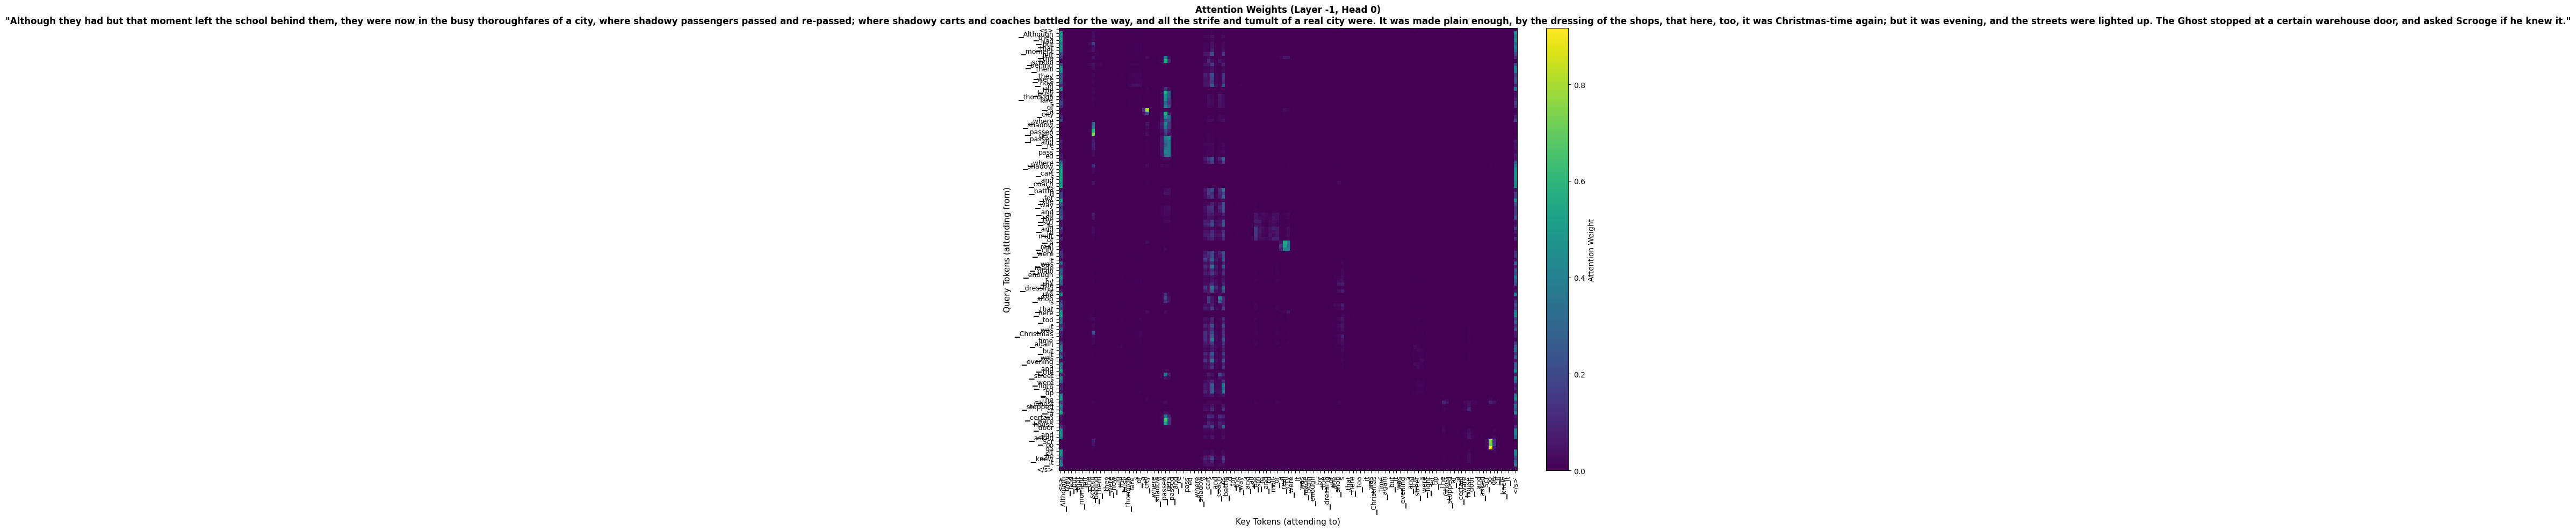


Visualizing: French
Text: Les cabines roulantes, attelées d'un cheval, remontaient aussi; et sur les planches de la promenade,...
✓ Saved to ..\results\attention_french.png


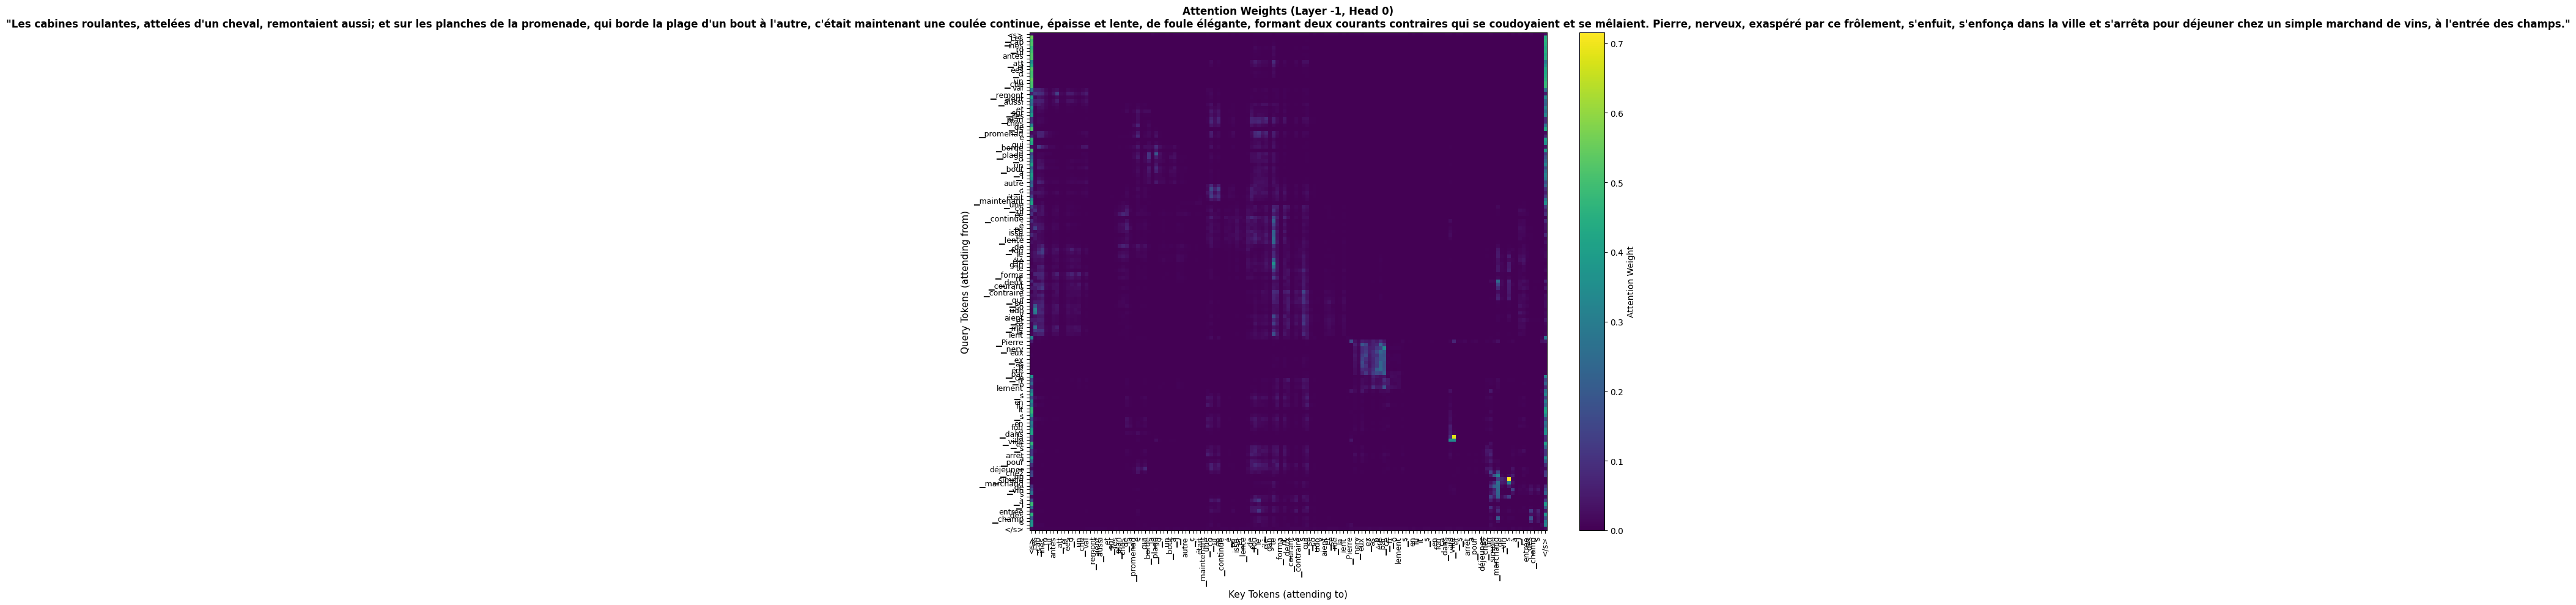


Visualizing: Italian
Text: E parve che Geppetto, sebbene fosse molto lontano dalla spiaggia, riconoscesse il figliuolo, perchè ...
✓ Saved to ..\results\attention_italian.png


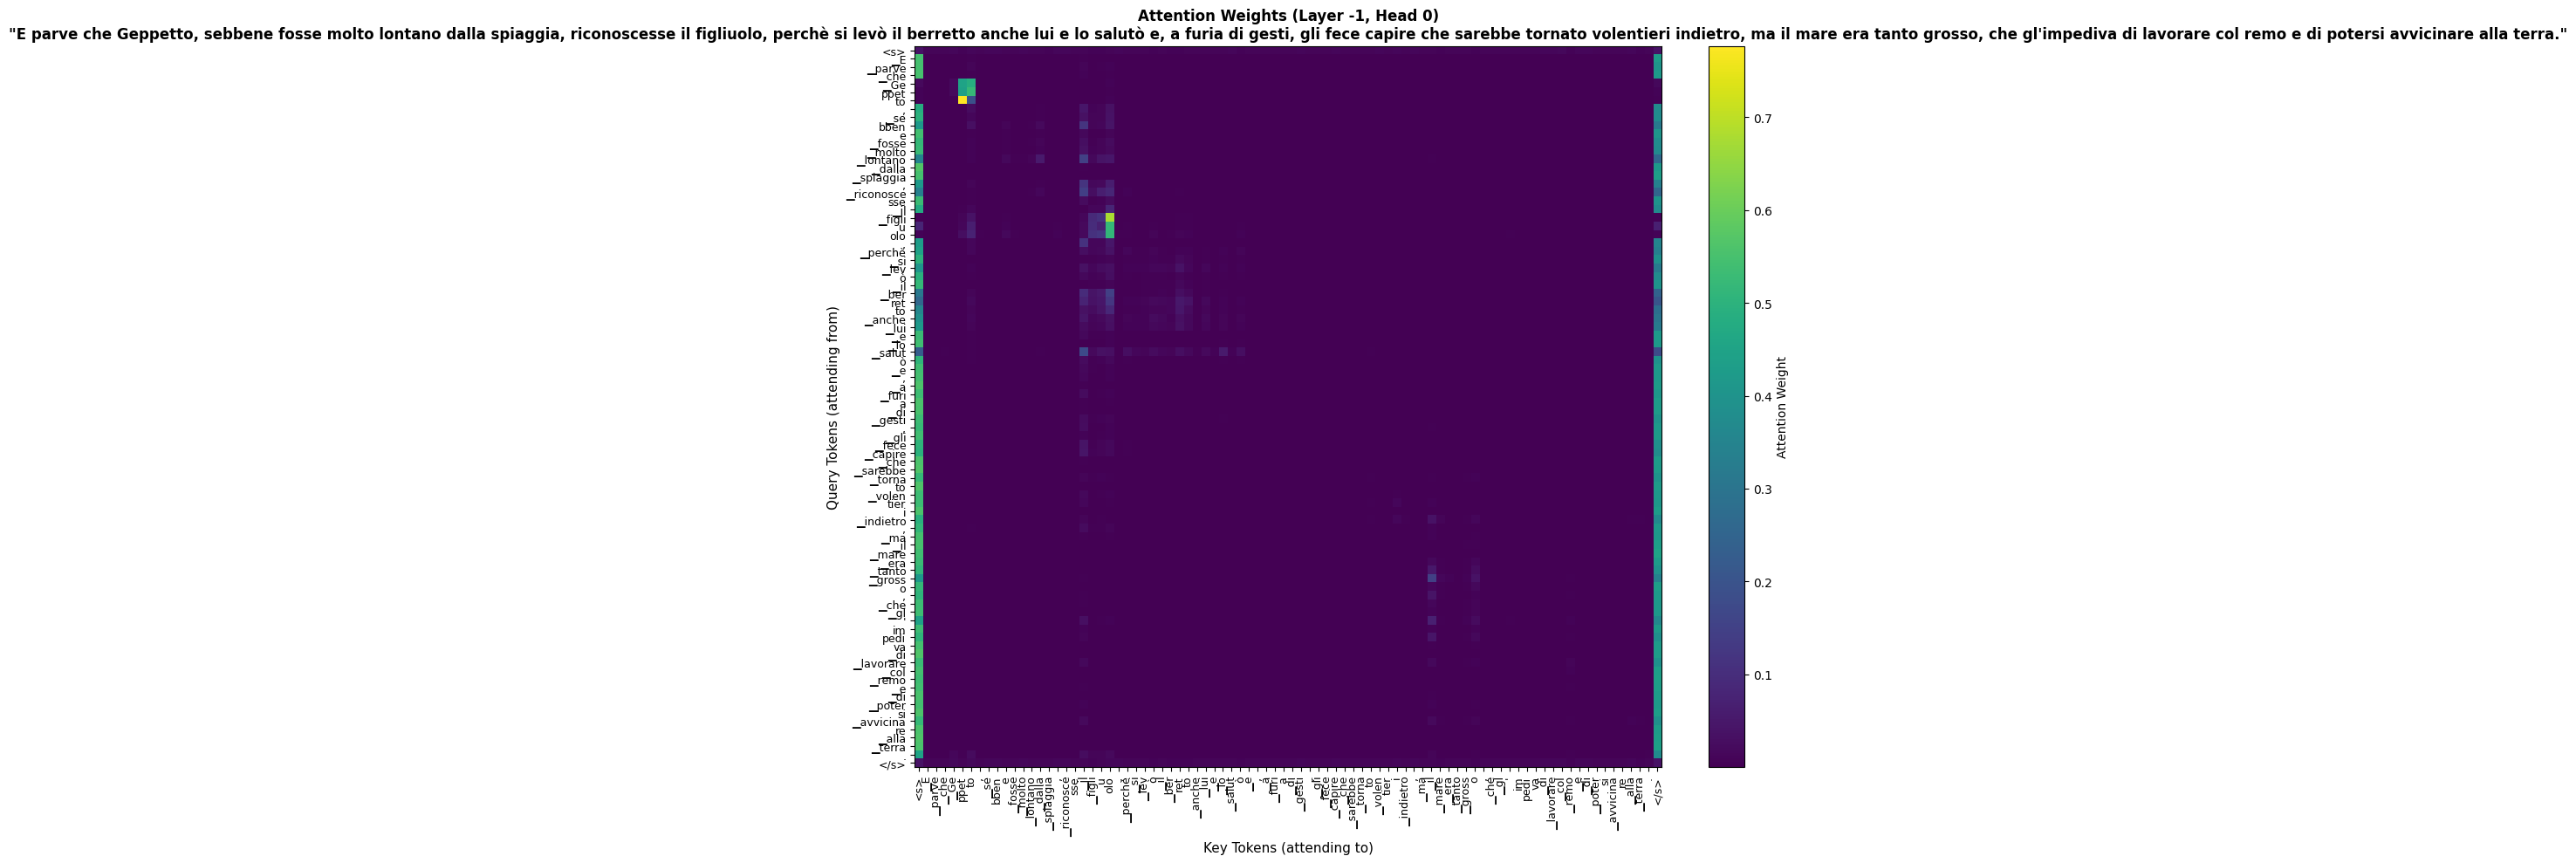


✓ All attention visualizations complete


In [10]:
# Visualize attention for the example sentences used above
example_sentences = [
    ("English", test_sentence),
    ("French", french_text),
    ("Italian", italian_text)
]

print("\n" + "="*60)
print("ATTENTION WEIGHT VISUALIZATIONS")
print("="*60)

for lang, text in example_sentences:
    print(f"\nVisualizing: {lang}")
    print(f"Text: {text[:100]}...")  # Show first 100 chars
    
    fig = visualize_attention(text, model, tokenizer, layer=-1, head=0)
    
    # Save figure
    filename = f"attention_{lang.lower()}.png"
    fig.savefig(RESULTS_PATH / filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved to {RESULTS_PATH / filename}")
    
    plt.show()
    plt.close()

print("\n✓ All attention visualizations complete")

In [10]:
def visualize_attention(text, model, tokenizer, layer=-1, head=0):
      """
      Visualize attention weights for a single text example.

      Args:
          text: Input text string
          model: Trained XLM-RoBERTa model
          tokenizer: Tokenizer
          layer: Which layer to visualize (-1 for last layer)
          head: Which attention head to visualize
      """
      # Tokenize input
      inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=128)

      # Get the device the model is on
      device = next(model.parameters()).device

      # Move inputs to the same device as the model
      inputs = {k: v.to(device) for k, v in inputs.items()}

      # Get model outputs with attention weights
      with torch.no_grad():
          outputs = model(**inputs, output_attentions=True)

      # Extract attention weights
      # Shape: (batch_size, num_heads, seq_len, seq_len)
      attention = outputs.attentions[layer][0, head].cpu().numpy()

      # Get tokens for visualization
      tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0].cpu())

      # Create visualization
      fig, ax = plt.subplots(figsize=(12, 10))

      # Plot heatmap
      im = ax.imshow(attention, cmap='viridis', aspect='auto')

      # Set ticks and labels
      ax.set_xticks(range(len(tokens)))
      ax.set_yticks(range(len(tokens)))
      ax.set_xticklabels(tokens, rotation=90, fontsize=8)
      ax.set_yticklabels(tokens, fontsize=8)

      # Add colorbar
      plt.colorbar(im, ax=ax, label='Attention Weight')

      # Labels
      ax.set_xlabel('Key Position', fontsize=11)
      ax.set_ylabel('Query Position', fontsize=11)
      ax.set_title(f'Attention Weights (Layer {layer}, Head {head})',
                   fontsize=12, fontweight='bold')

      plt.tight_layout()
      return fig